In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
def clean_dataframe_column_names(df):
    cols = df.columns
    new_column_names = []

    for col in cols:
        new_col = col.lstrip().rstrip().lower().replace (" ", "_") #strip beginning spaces, makes lowercase, add underscpre
        new_column_names.append(new_col)

    df.columns = new_column_names

In [3]:
recovery_rate = 0.4 #according to Moody
interest_rate = 0.0013 #US overnight rate

In [4]:
df = pd.read_excel('CDX.NA.HY_May_2020.xlsx', index_col=0, header=0)
df = df[df.Include == 1].drop('Include', axis=1)
clean_dataframe_column_names(df)

#generate bps spread
df['spread_%'] = df['spread_(bp)']/10000

#generate RN prob of default, quarterly payment
n_payment = 4

df['rn_prob_default_Q1'] = df['spread_%']/(n_payment*(1-recovery_rate))

df

,company_name,wgt,corp_tkr,5_yr_cds_tkr,spread_(bp),spread_%,rn_prob_default_Q1
#,,,,,,,
1,Advanced Micro Devices Inc,1,AMD,CT355268,58.0,0.0058,0.002417
2,AK Steel Corp,1,AKS,CAKS1U5,601.0,0.0601,0.025042
3,American Airlines Group Inc,1,AAL,CAMR1U5,6534.0,0.6534,0.272250
4,American Axle & Manufacturing Inc,1,AXL,CT370292,716.0,0.0716,0.029833
5,Amkor Technology Inc,1,AMKR,CT356410,138.0,0.0138,0.005750
...,...,...,...,...,...,...,...
95,Universal Health Services Inc,1,UHS,CT357677,74.0,0.0074,0.003083
96,Univision Communications Inc,1,UVN,CX376096,524.0,0.0524,0.021833
97,Vistra Energy Corp,1,VST,CY372142,153.0,0.0153,0.006375


In [43]:
#Manually change the recovery rate on American airline from 40% to 25% to represent higher risk due to Covid19
df.loc[df.company_name=='American Airlines Group Inc', 'rn_prob_default_Q1'] = df['spread_%']/(n_payment*(1-0.25))

df[df.company_name=='American Airlines Group Inc']

,company_name,wgt,corp_tkr,5_yr_cds_tkr,spread_(bp),spread_%,rn_prob_default_Q1,A_k,relative_A_k
#,,,,,,,,,
3,American Airlines Group Inc,1,AAL,CAMR1U5,6534.0,0.6534,0.2178,-0.081702,-0.000086


In [44]:
df['rn_prob_default_Q1'].describe()

count    92.000000
mean      0.027556
std       0.034388
min       0.002417
25%       0.006865
50%       0.015625
75%       0.029208
max       0.217800
Name: rn_prob_default_Q1, dtype: float64

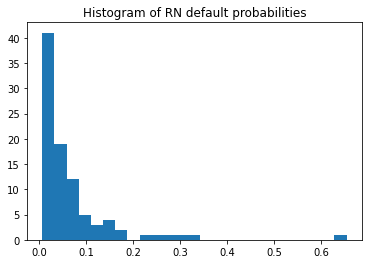

In [45]:
plt.hist(df['spread_%'], bins=25)
plt.title("Histogram of RN default probabilities")
plt.show()

In [13]:
#Date of the assignment 2020-05-18, CDS expires on 2025-06-20
end_date = pd.Timestamp('2025-06-20')
start_date = pd.Timestamp('2020-05-18')

#This is such that there are 21 observations period
n_periods = 21

'''
Assumptions for simplicity: the term structure of (continuously compounded) riskless interest rates is flat, constant and equal to 0.33% per year and that the term structure of CDS premia for each of the names is
also flat.
'''

In [46]:
def gen_Q_t(spread_bps): 
    
    Q_t = list()
    Q_1 = 1-(spread_bps/10000)/(1-recovery_rate)
    Q_t.append(Q_1)
    
    for i in range(2,n_periods):
        Q_t.append(Q_1**i)
        
    return Q_t

#Generate discount factors, assuming 4 periods per year

discount_factors = [1/(1 + interest_rate/4)**x for x in range(1,n_periods)]
    

def gen_A(spread_bps):
    
    Q_t = gen_Q_t(spread_bps) 
    
    A = np.multiply(Q_t, discount_factors)
    
    return sum(A)
    

In [53]:
#Calculate value of risky annuity
df['A_k'] = df['spread_(bp)'].apply(gen_A)



#Find total value of risky annuities
total_A_k = df.A_k.sum()

df['relative_A_k'] = df['A_k']/total_A_k
df['relative_S_k'] = df['relative_A_k'] * df['spread_(bp)']

# The total spread is equal to the sum of the individual spread weigthed by the value of the risky annuity
index_spread = df.relative_S_k.sum()

df

,company_name,wgt,corp_tkr,5_yr_cds_tkr,spread_(bp),spread_%,rn_prob_default_Q1,A_k,relative_A_k,relative_S_k
#,,,,,,,,,,
1,Advanced Micro Devices Inc,1,AMD,CT355268,58.0,0.0058,0.002417,18.029357,0.019004,1.102252
2,AK Steel Corp,1,AKS,CAKS1U5,601.0,0.0601,0.025042,7.876724,0.008303,4.989909
3,American Airlines Group Inc,1,AAL,CAMR1U5,6534.0,0.6534,0.217800,-0.081702,-0.000086,-0.562709
4,American Axle & Manufacturing Inc,1,AXL,CT370292,716.0,0.0716,0.029833,6.784036,0.007151,5.120045
5,Amkor Technology Inc,1,AMKR,CT356410,138.0,0.0138,0.005750,15.756248,0.016608,2.291946
...,...,...,...,...,...,...,...,...,...,...
95,Universal Health Services Inc,1,UHS,CT357677,74.0,0.0074,0.003083,17.543963,0.018493,1.368460
96,Univision Communications Inc,1,UVN,CX376096,524.0,0.0524,0.021833,8.748452,0.009222,4.832090
97,Vistra Energy Corp,1,VST,CY372142,153.0,0.0153,0.006375,15.370421,0.016202,2.478847


In [54]:
index_spread

338.7856037487672

More info are available https://www.markit.com/Company/Files/DownloadFiles?CMSID=1ec08990b6814532ad075e242b34160d